In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from keras.models import Sequential  
from keras.layers import *  
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model


# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')



/kaggle/input/filteredcsv-crispr/FINAL_FILTERED_CRISPR_DATA.csv


<ipython-input-1-b726eb54b9a5>:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
#Sets up the data
cas = pd.read_csv('../input/filteredcsv-crispr/FINAL_FILTERED_CRISPR_DATA.csv')
sequences = cas['30mer']
numerical_features = cas[['Percent Peptide', 'Amino Acid Cut position', 'score_drug_gene_rank']]
labels = cas['predictions']

cas.head()

,Unnamed: 0,30mer,Target gene,Percent Peptide,Amino Acid Cut position,score_drug_gene_rank,score_drug_gene_threshold,drug,predictions,model_predictions,predictions(30mer)
0,0,CAGAAAAAAAAACACTGCAACAAGAGGGTA,CD5,72.87,360.0,0.083682,0,nodrug,0.544412,[0.50806356],[0.4836564]
1,1,TTTTAAAAAACCTACCGTAAACTCGGGTCA,NF1,65.80,1868.0,0.868207,1,PLX_2uM,0.617512,[0.62796874],[0.55252229]
2,2,TCAGAAAAAGCAGCGTCAGTGGATTGGCCC,CD5,84.21,416.0,0.184100,0,nodrug,0.476232,[0.43904996],[0.48895234]
3,3,AATAAAAAATAGGATTCCCAGCTTTGGAAG,NF1,56.39,1601.0,0.432065,0,PLX_2uM,0.459882,[0.41283168],[0.38075222]
4,4,GATGAAAAATATGTAAACAGCATTTGGGAC,CUL3,4.30,33.0,0.149351,0,PLX_2uM,0.290841,[0.24229578],[0.25223681]


In [3]:

tokenizer = Tokenizer(char_level=True)  # Treat each nucleotide as a character
tokenizer.fit_on_texts(sequences)
sequences_encoded = tokenizer.texts_to_sequences(sequences)
sequences_padded = pad_sequences(sequences_encoded, maxlen=30)  # 30mer

# Normalization
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

# Split the data into training and testing sets
X_seq_train, X_seq_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    sequences_padded, numerical_features_scaled, labels, test_size=0.2, random_state=42
)


(X_seq_train.shape, X_seq_test.shape, X_num_train.shape, X_num_test.shape, y_train.shape, y_test.shape)

((4248, 30), (1062, 30), (4248, 3), (1062, 3), (4248,), (1062,))

In [4]:
# Define the model extra features
seq_input = Input(shape=(30,), name='seq_input')
embedding = Embedding(input_dim=5, output_dim=16)(seq_input)
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten_seq = Flatten()(pool2)


In [5]:
# input for numerical collumns
num_input = Input(shape=(3,), name='num_input')
bn1 = BatchNormalization()(num_input)
dense1 = Dense(256, activation='relu')(bn1)
bn2 = BatchNormalization()(dense1)
dropout1 = Dropout(0.3)(bn2)
dense2 = Dense(256, activation='relu')(dropout1)
bn3 = BatchNormalization()(dense2)
dropout2 = Dropout(0.3)(bn3)
dense3 = Dense(128, activation='relu')(dropout2)

In [6]:
# Combine the features
combined = Concatenate()([flatten_seq, dense3])
fc_combined = Dense(64, activation='relu')(combined)
output = Dense(1, activation='linear', name='output')(fc_combined)

In [7]:
# Model
model = Model(inputs=[seq_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [8]:
# Training
history = model.fit(
    [X_seq_train, X_num_train],
    y_train,
    validation_data=([X_seq_test, X_num_test], y_test),
    epochs=30,
    batch_size=32
)

Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0538 - mean_squared_error: 0.0538 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.00

In [9]:
# Test the efficiency
test_loss, test_mse = model.evaluate([X_seq_test, X_num_test], y_test)
print(f"Test Loss: {test_loss}, Test MSE: {test_mse}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Test Loss: 0.0024250266142189503, Test MSE: 0.0024250266142189503


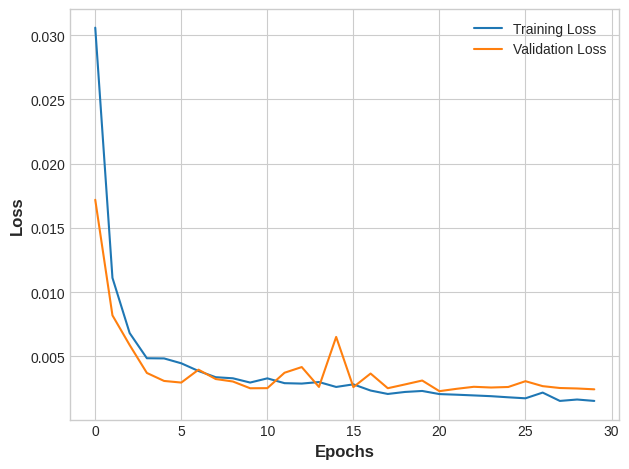

In [10]:
# Graph the training 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Training using all data
history_full = model.fit(
    [sequences_padded, numerical_features_scaled],
    labels,
    epochs=30,
    batch_size=32
)

print("Model retrained on the full dataset.")


Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 9/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 10/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 11/30
166/166 ━━━━━━━━━━━━━━━━━━━

In [12]:
test_sequence = "CAGAAAAAAAAACACTGCAACAAGAGGGTA"
test_num_feat = np.array([[72.87, 360, 0.083682008]]) #percent peptide, cut position, score_drug_gene_rank

# Preprocessing
test_sequence_encoded = tokenizer.texts_to_sequences([test_sequence])
test_sequence_padded = pad_sequences(test_sequence_encoded, maxlen=30)
test_numerical_features_scaled = scaler.transform(test_num_feat)

# Predict
prediction = model.predict([test_sequence_padded, test_numerical_features_scaled])
print(f"Predicted Efficiency: {prediction[0][0]}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Predicted Efficiency: 0.5633714199066162
